![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

## <h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

### <h2> 3.1 Reading data and basic stats </h2>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df = pd.read_csv("/content/gdrive/My Drive/Quora case study/train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [0]:
df.head()

id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0
2   2     5  ...  How can Internet speed be increased by hacking...            0
3   3     7  ...  Find the remainder when [math]23^{24}[/math] i...            0
4   4     9  ...            Which fish would survive in salt water?            0

[5 rows x 6 columns]

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

### <h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

In [0]:
df.groupby("is_duplicate").count()

id    qid1    qid2  question1  question2
is_duplicate                                              
0             255027  255027  255027     255026     255025
1             149263  149263  149263     149263     149263

In [0]:
df.groupby("is_duplicate")['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

Data is unbalanced, let it be will balance while applying model, 
Note: While splitting for X_train and X_test use Stratify to maintain the same balance

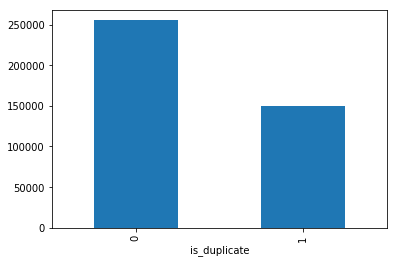

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [0]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


### <h3> 3.2.2 Number of unique questions </h3>

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())  # appending both the Qid to a list
unique_qs = len(np.unique(qids))  # calling Unique fn 
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



### For my understanding staring **********************

In [0]:
df["qid1"].nunique()

290654

In [0]:
df["qid1"].shape

(404290,)

In [0]:
qids

0              1
1              3
2              5
3              7
4              9
5             11
6             13
7             15
8             17
9             19
10            21
11            23
12            25
13            27
14            29
15            31
16            33
17            35
18            37
19            39
20            41
21            43
22            45
23            47
24            49
25            51
26            53
27            55
28            57
29            59
           ...  
808550       691
808551    124172
808552    466328
808553    537906
808554    537908
808555     16064
808556    146284
808557    290649
808558    537910
808559    349794
808560     35364
808561    537914
808562     14005
808563    537916
808564     87385
808565    537917
808566    308365
808567    537918
808568    169786
808569    537921
808570    537923
808571     81495
808572     16773
808573    537925
808574    537927
808575    379845
808576    155606
808577    5379

In [0]:
qids.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
17978      77
2675       68
28764      66
1772       63
24555      61
18753      58
4018       57
28133      56
3595       55
19621      55
18531      55
4951       55
13748      54
10024      54
10330      54
38         54
18296      53
11264      52
6551       52
20190      52
691        51
8461       51
6749       51
2322       51
33412      51
         ... 
95599       1
87403       1
259391      1
89450       1
1345        1
7490        1
13639       1
19784       1
17737       1
23882       1
32078       1
30031       1
34129       1
40274       1
38227       1
42325       1
48470       1
56666       1
54619       1
60764       1
64862       1
62815       1
66913       1
73058       1
77156       1
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64

In [0]:
qids.value_counts() > 1

2559       True
30782      True
4044       True
2561       True
14376      True
17978      True
2675       True
28764      True
1772       True
24555      True
18753      True
4018       True
28133      True
3595       True
19621      True
18531      True
4951       True
13748      True
10024      True
10330      True
38         True
18296      True
11264      True
6551       True
20190      True
691        True
8461       True
6749       True
2322       True
33412      True
          ...  
95599     False
87403     False
259391    False
89450     False
1345      False
7490      False
13639     False
19784     False
17737     False
23882     False
32078     False
30031     False
34129     False
40274     False
38227     False
42325     False
48470     False
56666     False
54619     False
60764     False
64862     False
62815     False
66913     False
73058     False
77156     False
75109     False
81254     False
85352     False
83305     False
168274    False
Length: 537933, dtype: b

In [0]:
np.sum( qids.value_counts() > 1 )

111780

### My understanding finishing **********************

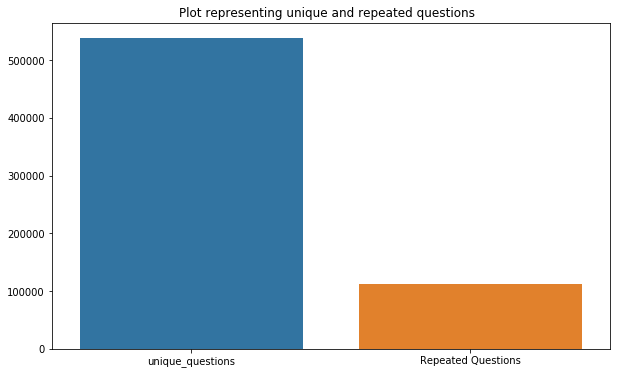

In [0]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### <h3>3.2.3 Checking for Duplicates </h3>

In [0]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### <h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



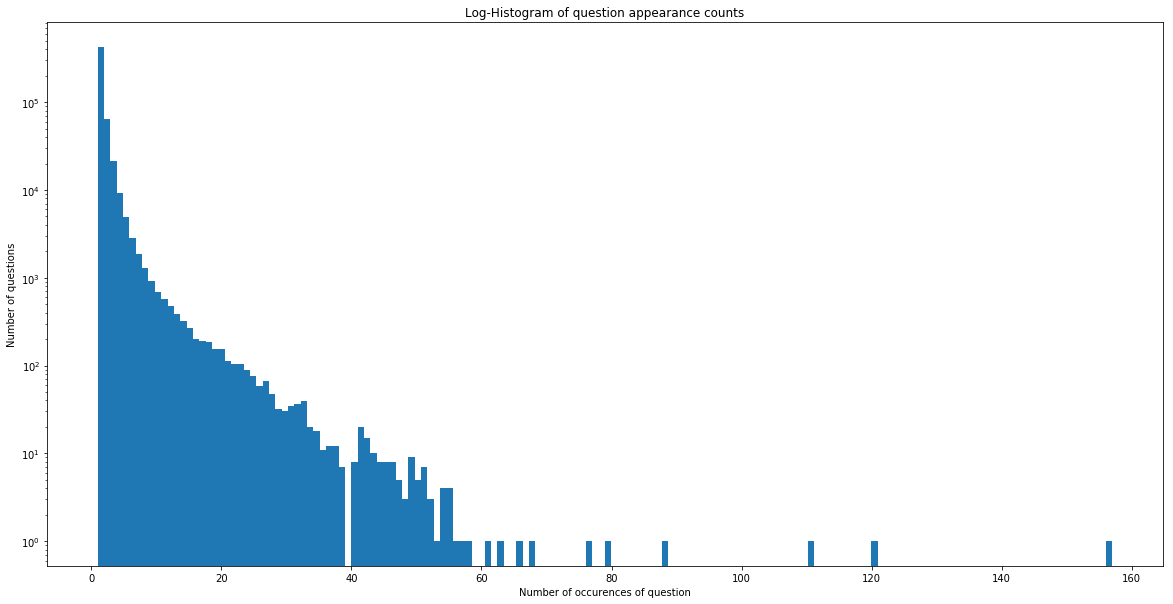

In [0]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

# https://stackoverflow.com/questions/17952279/logarithmic-y-axis-bins-in-python

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### <h3> 3.2.5 Checking for NULL values </h3>

In [0]:
#Checking whether there are any rows with null values

nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


- There are two rows with null values in question2 

In [0]:
# Total 3 null values, two in Question2 and 1 in Question1

df[df.isnull().any(1)]

id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]

In [0]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [0]:
df[df.isnull().any(1)]

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

## Splitting the data to avoid data leakage

In [0]:
# picking 100000 (1-lakh) datapoints Randomly from 4L data points to reduce the Computational Complexity

print(df.shape)
df = df.sample(n=100000)
print(df.shape)

(404290, 6)
(100000, 6)


In [0]:
y = df['is_duplicate'].values
df.drop(['is_duplicate'], axis=1, inplace=True)
df.head(1)


id  ...                                 question2
223110  223110  ...  What was the first programming language?

[1 rows x 5 columns]

In [0]:
print( len(y) )
print(y.shape)


100000
(100000,)


In [0]:
X = df

print(X.shape)

(100000, 5)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test=train_test_split(X,y,test_size=0.30, stratify=y)


# stratify=y , which means here we are taking y as Resposne label.

# X_test,Y_test is future Unseen data.

print(X_train.shape)
print(X_test.shape)

(70000, 5)
(30000, 5)


In [0]:
# now X_train have 2,70,874 data points which is used as training dataset
# X_test have 1,33,416 data points which is uses as test data set
# there will be no dataleakage problem, Feature engineering has to be done seperately for both the Train and Test data set

## <h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [0]:
df_temp=pd.read_csv("/content/gdrive/My Drive/Quora case study/df_fe_without_preprocessing_train.csv", encoding = 'latin-1')

# df = pd.read_csv(r"D:\ss.csv", encoding="cp1252")

In [0]:
df_temp.head(2)

id  qid1  qid2  ... word_share freq_q1+q2  freq_q1-q2
0   0     1     2  ...   0.434783          2           0
1   1     3     4  ...   0.200000          5           3

[2 rows x 17 columns]

In [0]:
df.head(2)

print(df.shape)

# assiging the X_train as df 

df = X_train

print(df.shape)

(100000, 5)
(70000, 5)


In [0]:
if os.path.isfile('/content/gdrive/My Drive/Quora case study/df_fe_without_preprocessing_xtrain.csv'):
    df = pd.read_csv("/content/gdrive/My Drive/Quora case study/df_fe_without_preprocessing_xtrain.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') # how many times one, three has occured etc... # remember the difference between df.groupby('qid1')['qid1'].count() --> this will give count for each unique elements
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count') # how many times two, four has occured etc...
    df['q1len'] = df['question1'].str.len() # calculate total number of characters
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))  # calculate total number of words
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2)) 
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
 
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("/content/gdrive/My Drive/Quora case study/df_fe_without_preprocessing_xtrain.csv", index=False)

df.head(2)

id    qid1    qid2  ... word_share freq_q1+q2  freq_q1-q2
0  223298  331079  331080  ...   0.105263          2           0
1  290167  411409  411410  ...   0.222222          2           0

[2 rows x 16 columns]

In [0]:
print(df.shape)

(70000, 16)


In [0]:
df1 = X_test

print(df1.shape)

(30000, 5)


In [0]:
if os.path.isfile('/content/gdrive/My Drive/Quora case study/df_fe_without_preprocessing_xtest.csv'):
    df1 = pd.read_csv("/content/gdrive/My Drive/Quora case study/df_fe_without_preprocessing_xtest.csv",encoding='latin-1')
else:
    df1['freq_qid1'] = df1.groupby('qid1')['qid1'].transform('count') # how many times one, three has occured etc... # remember the difference between df.groupby('qid1')['qid1'].count() --> this will give count for each unique elements
    df1['freq_qid2'] = df1.groupby('qid2')['qid2'].transform('count') # how many times two, four has occured etc...
    df1['q1len'] = df1['question1'].str.len() # calculate total number of characters
    df1['q2len'] = df1['question2'].str.len()
    df1['q1_n_words'] = df1['question1'].apply(lambda row: len(row.split(" ")))  # calculate total number of words
    df1['q2_n_words'] = df1['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df1['word_Common'] = df1.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2)) 
    df1['word_Total'] = df1.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df1['word_share'] = df1.apply(normalized_word_share, axis=1)

    df1['freq_q1+q2'] = df1['freq_qid1']+df1['freq_qid2']
    df1['freq_q1-q2'] = abs(df1['freq_qid1']-df1['freq_qid2'])

    df1.to_csv("/content/gdrive/My Drive/Quora case study/df_fe_without_preprocessing_xtest.csv", index=False)

df1.head()

id    qid1    qid2  ... word_share freq_q1+q2  freq_q1-q2
0  168712  261259  261260  ...   0.428571          2           0
1  316560    8507  441633  ...   0.151515          2           0
2   71998   13480   28111  ...   0.222222          2           0
3  402566  536054  536055  ...   0.153846          2           0
4   39940   72342   72343  ...   0.000000          2           0

[5 rows x 16 columns]

In [0]:
print(df.shape)
print(df1.shape)

(70000, 16)
(30000, 16)


**NOTE:  df = train data, 
df1 = test data**

In [0]:
# df['question1'].str[:].apply(len) is same as df['question1'].str.len() 

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 13
Number of Questions with minimum length [question2] : 3


<h4> 3.3.1.1 Feature: word_share </h4>

In [0]:
print(len(Y_train))
print(len(Y_test))

70000
30000


In [0]:
# lets add is duplicate Column to df and df1 

df["is_duplicate"] = Y_train
print(df.shape) # one column must have increased

(70000, 17)


In [0]:
print(df1.shape)
df1["is_duplicate"] = Y_test
print(df1.shape)

(30000, 16)
(30000, 17)


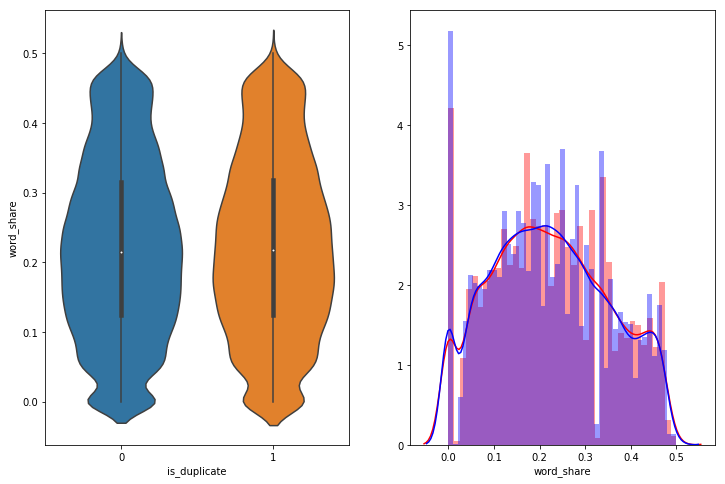

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

## Observation:
 

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

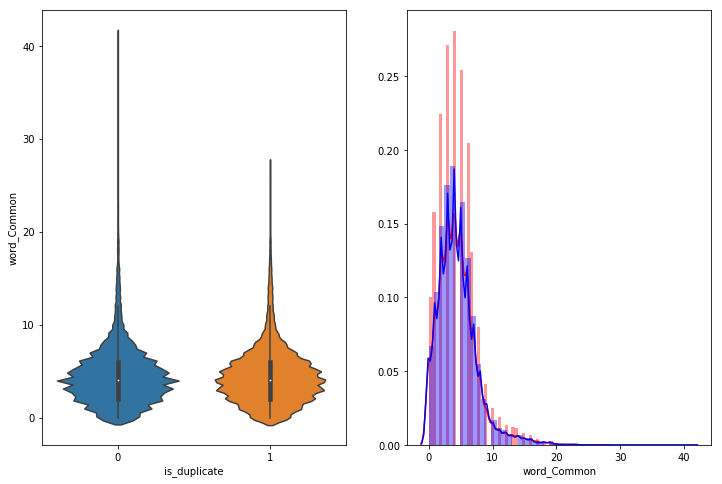

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

## Observation:
 
<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## 3.4 : EDA: Advanced Feature Extraction.


In [0]:
! pip install distance
! pip install fuzzywuzzy

     |████████████████████████████████| 184kB 45.8MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp36-none-any.whl size=16261 sha256=9d84069b5424c2352cfc195915df65a52f2e5f38f0102d0b2fa42f0936d0a9d0
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

###  <h2> 3.4.1 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [0]:
# Using regular expression we are doing some text preprocessing
# Example text for Understanding

text = "6000000   4000"
print(text)
text = re.sub(r"([0-9]+)000000", r"\1m", text)
print(text)

text = re.sub(r"([0-9]+)000", r"\1k", text)
print(text)

6000000   4000
6m   4000
6m   4k


In [0]:
# Example text for Understanding

text = "hello boys #"
print(text)
pattern = re.compile('\W')
text = re.sub(pattern, ' ', text)
print(text)

hello boys #
hello boys  


In [0]:
# Example text for Understanding
# Stemming 

text = "teaching"
print(text)
porter = PorterStemmer()
text = porter.stem(text)
print(text)

teaching
teach


In [0]:
# Example text for Understanding
# Beautiful soup example

text = "<title> hello </title>"
print(text)
example1 = BeautifulSoup(text)
text = example1.get_text()
print(text)

<title> hello </title>
 hello 


In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

import nltk
nltk.download('stopwords')

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

## <h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
# Example text for Understanding

text = "hello this is testing text"
q1_tokens = text.split()

print(text)

print(q1_tokens)

q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])

print(q1_words)

q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])

print (q1_stops)

hello this is testing text
['hello', 'this', 'is', 'testing', 'text']
{'text', 'testing', 'hello'}
{'this', 'is'}


In [0]:
txt1 = "hello quest ww one"
txt2 = "hello quest two"
distance.lcsubstrings(txt1, txt2)

{'hello quest '}

In [0]:
print(type(distance.lcsubstrings(txt1, txt2)))
strs = list (distance.lcsubstrings(txt1, txt2))
print(type(strs))
print(strs)
print(strs[0])

<class 'set'>
<class 'list'>
['hello quest ']
hello quest 


In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    # Absolute difference Token Length of both Questions 
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [0]:
print(df.shape)
print(df1.shape)

(70000, 17)
(30000, 17)


###  Saving the basic feature and Advanced feature to reduce, calculating the feature again and again

In [0]:
# applying these Feature engineering Technique in Both train(df) and test data(df1) 

if os.path.isfile('/content/gdrive/My Drive/Quora case study/nlp_features_xtrain.csv'):
  print("Train Data alredy found")
  df = pd.read_csv("/content/gdrive/My Drive/Quora case study/nlp_features_xtrain.csv",encoding='latin-1')
  df.fillna('')
else:
  print("Extracting Own features for Train data........")
  df = extract_features(df)
  print("Saving the Data set")
  df.to_csv("/content/gdrive/My Drive/Quora case study/nlp_features_xtrain.csv", index=False)

  

if os.path.isfile('/content/gdrive/My Drive/Quora case study/nlp_features_xtest.csv'):
  print("Test Data alredy found")
  df1 = pd.read_csv("/content/gdrive/My Drive/Quora case study/nlp_features_xtest.csv",encoding='latin-1')
  df1.fillna('')
else:
  print("Extracting Own features for Test data........")
  df1 = extract_features(df1)
  print("Saving the Data set")
  df1.to_csv("/content/gdrive/My Drive/Quora case study/nlp_features_xtest.csv", index=False)

  
print(df.shape)
print(df1.shape)

Train Data alredy found
Test Data alredy found
(70000, 32)
(30000, 32)


In [0]:
# Saving the final Feature Engineered data frame to Drive, so no need of Feature Engineer every time
# This data frame have, basic feature eng + advanced Feature Eng 
# train = df = 70000 datapoints, 32 features incluing is_duplicate
# test = df1 = 30000 datapoints, 32 features incluing is_duplicate

### <h3>3.5.1 Analysis of extracted features </h3>

#### <h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('/content/gdrive/My Drive/Quora case study/train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('/content/gdrive/My Drive/Quora case study/train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 51810
Number of data points in class 0 (non duplicate pairs) : 88190


In [0]:
# p is array of text, is_duplicate = 1 for Train points
# n is array of text, is_duplicate = 0 for Train points

# here, textp_w is string, conatining all the array of strings in p
# Because for wordcloud, we need long string, not array of string, we can use map fn also to do so

# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, '/content/gdrive/My Drive/Quora case study/train_p.txt')).read()
textn_w = open(path.join(d, '/content/gdrive/My Drive/Quora case study/train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 2808621
Total number of words in non duplicate pair questions : 5753103


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


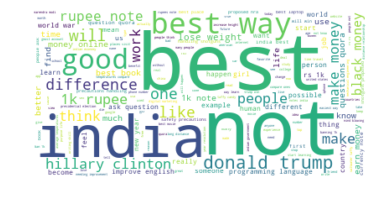

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


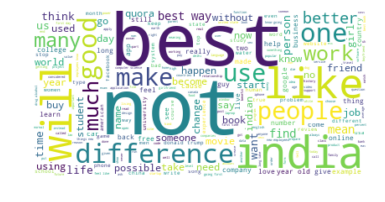

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Observation:
 
 * As we see some of the words are common in duplicate and non-duplicate pairs, so it could be hard to Classify the duplicate and non-duplicate pairs

### <h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

In [0]:
df.shape

(70000, 32)

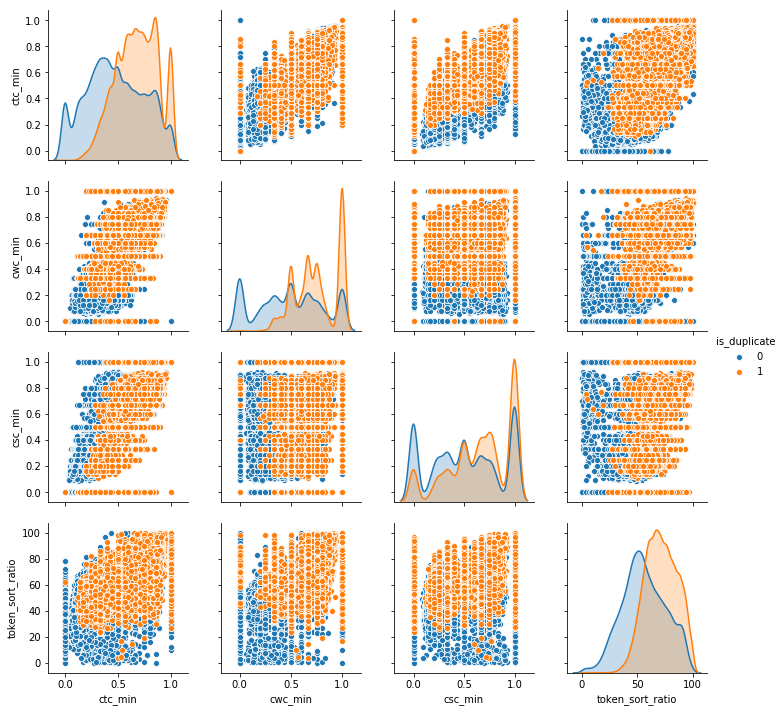

In [0]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

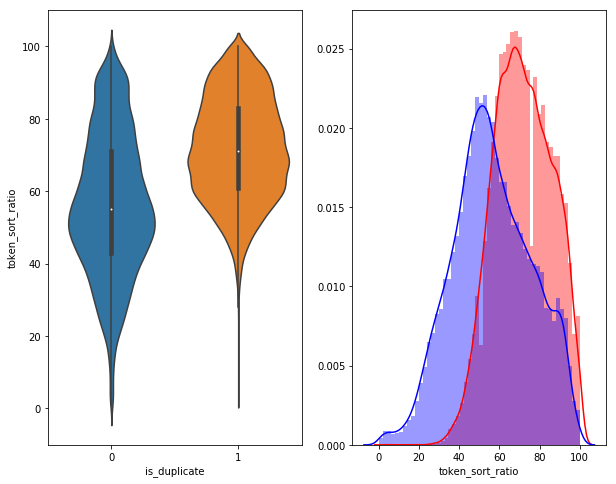

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

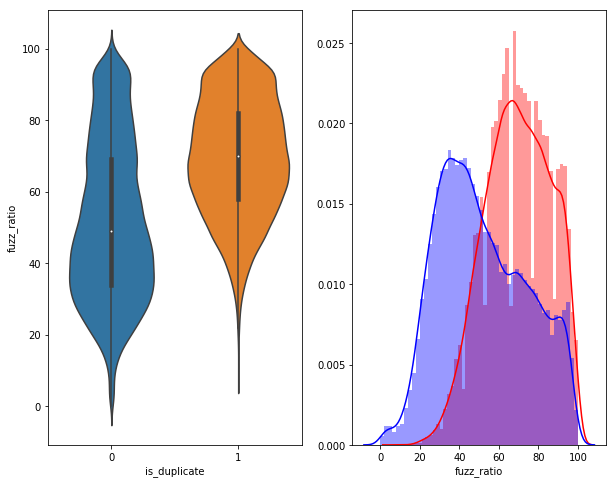

In [0]:
# Distribution of the fuzz_ratio

plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## Observation:
 
 * After the Advanced feature extraction, the fuzz ratio and Token Sort ratio for the Duplicate and non Duplicate pairs are not completely overlapping as earlier, but still its 80% overlapping.
 
 * From the box plot, using Token sort ratio and Fuzz ratio we can classify 30% of points correctly using simple model. 
 
 * Duplicate Questions have lower mean (Fuzz ratio and Token Sort ratio) value compared to, Non duplicate Questions

# <h3>3.5.2 Visualization </h3>

In [0]:
print(df.shape)

(70000, 32)


In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
print(dfp_subsampled.shape)
print(X.shape)

(5000, 32)
(5000, 15)


In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.323s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.145603
[t-SNE] Computed conditional probabilities in 0.257s
[t-SNE] Iteration 50: error = 82.5872650, gradient norm = 0.0463284 (50 iterations in 2.445s)
[t-SNE] Iteration 100: error = 71.0488586, gradient norm = 0.0102039 (50 iterations in 1.602s)
[t-SNE] Iteration 150: error = 69.2050247, gradient norm = 0.0058378 (50 iterations in 1.508s)
[t-SNE] Iteration 200: error = 68.4652023, gradient norm = 0.0042964 (50 iterations in 1.504s)
[t-SNE] Iteration 250: error = 68.0366592, gradient norm = 0.0040901

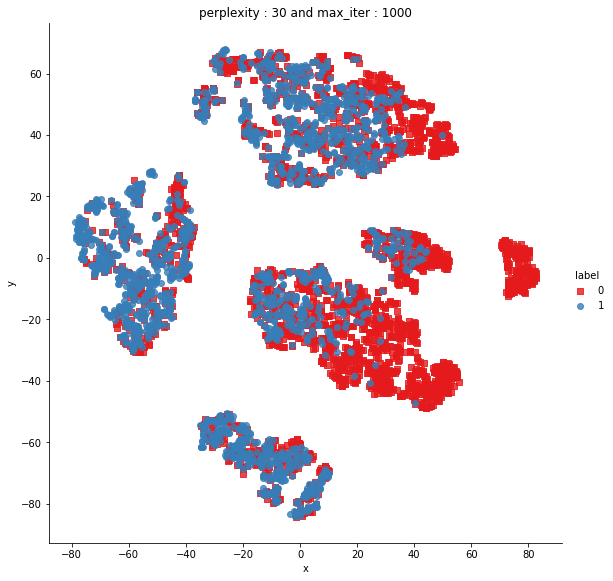

In [0]:
df_tsne = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_tsne, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.341s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.145603
[t-SNE] Computed conditional probabilities in 0.258s
[t-SNE] Iteration 50: error = 84.0958023, gradient norm = 0.0437084 (50 iterations in 10.899s)
[t-SNE] Iteration 100: error = 69.9692078, gradient norm = 0.0033217 (50 iterations in 5.374s)
[t-SNE] Iteration 150: error = 68.6240234, gradient norm = 0.0017299 (50 iterations in 4.627s)
[t-SNE] Iteration 200: error = 68.0782013, gradient norm = 0.0011488 (50 iterations in 4.727s)
[t-SNE] Iteration 250: error = 67.7639847, gradient norm = 0.000841

In [0]:
# https://www.youtube.com/watch?v=F2pAu9PzgEE

def configure_plotly_browser_state():
	import IPython
	display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>
					<script>
					requirejs.config({
					paths: {
						base: '/static/base',
						plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
						}, });  </script> '''))

In [0]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(200, 200, 200)'),
        opacity=1,
        size = 5
    )
)

data=[trace1]
layout=dict(height=800, width=1400, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')
plt.show()

## Observation:
 
 * As we see 3d Embedding of Engineered Features, some of blue poins (Non duplicate) are isolated, which means thery are seperable from Dulicate Question.
 * But most of points(similar and non-similar questions) are Clustered

# <h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [0]:
print(df.shape)
print(df1.shape)

(70000, 32)
(30000, 32)


In [0]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [0]:
# converting Question1 and Question2 columns into string

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
df1['question1'] = df1['question1'].apply(lambda x: str(x))
df1['question2'] = df1['question2'].apply(lambda x: str(x))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts of train data
train_questions = list(df['question1']) + list(df['question2'])


tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit(train_questions)
tfidf.transform(train_questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
len(tfidf.idf_)

39199

In [0]:
len(tfidf.get_feature_names())

39199

In [0]:
len(train_questions)

140000

In [0]:
#  word2tfidf = this will contain the Words in the Question1 and Question2 an their corresponding Tfidf values
# remember we fit and transform only the train data, we should use the same for test data to avoid Data leakage

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

##### train data Question 1 

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')  # loading the Document         #  en_core_web_lg

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])): # Taking out each question
    doc1 = nlp(qu1) # Applying the nlp instance to the Entire Question, so we can get the w2v represenataion of that Question 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])  # 13 X 96
    for word1 in doc1:  # Taking out each word in that Questions
        # word2vec
        vec1 = word1.vector   # Taking vector representation of the each word in the question, so we can apply term-frequency technique
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]  # Getting the term frequency of the corresponding word, and storing into idf
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)   # 13 X 96  into 1 X 96 (here we have vector representation for each word multiplied with their corrosponding term frequency 
                                          # multiplied, we are making avgerage vector for W2v concept, of the entire sentence (i.e) Question 1)
    vecs1.append(mean_vec1)              # here we are appending them to vecs1, so it will contain vector for each Questions in Qid1
train_tfidfw2v_q1 = pd.DataFrame(list(vecs1))           # Converting into list


100%|██████████| 70000/70000 [08:24<00:00, 138.81it/s]


In [0]:
print(train_tfidfw2v_q1.shape)

(70000, 96)


##### train data Question 2

In [0]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
train_tfidfw2v_q2 = pd.DataFrame(list(vecs2))

100%|██████████| 70000/70000 [08:18<00:00, 145.11it/s]


In [0]:
print(train_tfidfw2v_q2.shape)

(70000, 96)


##### test data Question 1

Remember for test data we are using the tfidf technique which is fitted on test data only to avoid Data leakage

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')  # loading the Document         #  en_core_web_lg

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df1['question1'])): # Taking out each question
    doc1 = nlp(qu1) # Applying the nlp instance to the Entire Question, so we can get the w2v represenataion of that Question 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])  # 13 X 96
    for word1 in doc1:  # Taking out each word in that Questions
        # word2vec
        vec1 = word1.vector   # Taking vector representation of the each word in the question, so we can apply term-frequency technique
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]  # Getting the term frequency of the corresponding word, and storing into idf
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)   # 13 X 96  into 1 X 96 (here we have vector representation for each word multiplied with their corrosponding term frequency 
                                          # multiplied, we are making avgerage vector for W2v concept, of the entire sentence (i.e) Question 1)
    vecs1.append(mean_vec1)              # here we are appending them to vecs1, so it will contain vector for each Questions in Qid1
test_tfidfw2v_q1 = pd.DataFrame(list(vecs1))           # Converting into list

100%|██████████| 30000/30000 [03:33<00:00, 140.73it/s]


In [0]:
print(test_tfidfw2v_q1.shape)

(30000, 96)


In [0]:
test_tfidfw2v_q1.head(2)

0          1          2   ...         93         94          95
0  45.469684 -33.741539 -33.881337  ...  -7.722324  23.769249   25.351239
1   3.776985  57.678178 -63.183753  ...  40.926721 -75.706050  119.710604

[2 rows x 96 columns]

##### test data Question 2

Remember for test data we are using the tfidf technique which is fitted on test data only to avoid Data leakage

In [0]:

vecs2 = []
for qu2 in tqdm(list(df1['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
test_tfidfw2v_q2 = pd.DataFrame(list(vecs2))

100%|██████████| 30000/30000 [03:34<00:00, 139.76it/s]


In [0]:
print(test_tfidfw2v_q2.shape)

(30000, 96)


In [0]:
## Saving the dataframe to reduce the computation time next time
print("Saving the Data set train_tfidfw2v_q1")
train_tfidfw2v_q1.to_csv("/content/gdrive/My Drive/Quora case study/train_tfidfw2v_q1.csv", index=False)

print("Saving the Data set train_tfidfw2v_q2")
train_tfidfw2v_q2.to_csv("/content/gdrive/My Drive/Quora case study/train_tfidfw2v_q2.csv", index=False)


print("Saving the Data set test_tfidfw2v_q1")
test_tfidfw2v_q1.to_csv("/content/gdrive/My Drive/Quora case study/test_tfidfw2v_q1.csv", index=False)


print("Saving the Data set test_tfidfw2v_q2")
test_tfidfw2v_q2.to_csv("/content/gdrive/My Drive/Quora case study/test_tfidfw2v_q2.csv", index=False)


print("Saving the train Data set")
df.to_csv("/content/gdrive/My Drive/Quora case study/df_train.csv", index=False)

print("Saving the test Data set")
df1.to_csv("/content/gdrive/My Drive/Quora case study/df1_test.csv", index=False)

Saving the Data set train_tfidfw2v_q1
Saving the Data set train_tfidfw2v_q2
Saving the Data set test_tfidfw2v_q1
Saving the Data set test_tfidfw2v_q2
Saving the train Data set
Saving the test Data set


In [0]:
## Reading the dataframe

train_tfidfw2v_q1 = pd.read_csv("/content/gdrive/My Drive/Quora case study/train_tfidfw2v_q1.csv")

train_tfidfw2v_q2 = pd.read_csv("/content/gdrive/My Drive/Quora case study/train_tfidfw2v_q2.csv")

test_tfidfw2v_q1 =  pd.read_csv("/content/gdrive/My Drive/Quora case study/test_tfidfw2v_q1.csv")

test_tfidfw2v_q2 = pd.read_csv("/content/gdrive/My Drive/Quora case study/test_tfidfw2v_q2.csv")

df = pd.read_csv("/content/gdrive/My Drive/Quora case study/df_train.csv")

df1 = pd.read_csv("/content/gdrive/My Drive/Quora case study/df1_test.csv")

# <h2> 3.7 Featurizing text data with tfidf Technique </h2>

In [4]:
len(df["question1"].values)

70000

In [0]:
df[df.isnull().any(1)]
df = df.fillna('')

In [6]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, is_duplicate, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=10000)

#  https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

vectorizer.fit(df["question1"].values.astype('U'))

X_train_tfidf_q1 = vectorizer.transform(df["question1"].values.astype('U'))
X_test_tfidf_q1 = vectorizer.transform(df1["question1"].values.astype('U'))

vectorizer.fit(df["question2"].values.astype('U'))

X_train_tfidf_q2 = vectorizer.transform(df["question2"].values.astype('U'))
X_test_tfidf_q2 = vectorizer.transform(df1["question2"].values.astype('U'))


In [8]:
print("Shape of matrix after one hot encodig ",X_train_tfidf_q1.shape)
print("Shape of matrix after one hot encodig ",X_test_tfidf_q1.shape)
print("Shape of matrix after one hot encodig ",X_train_tfidf_q2.shape)
print("Shape of matrix after one hot encodig ",X_test_tfidf_q2.shape)

Shape of matrix after one hot encodig  (70000, 10000)
Shape of matrix after one hot encodig  (30000, 10000)
Shape of matrix after one hot encodig  (70000, 10000)
Shape of matrix after one hot encodig  (30000, 10000)


In [9]:
print("Number of features in nlp + preprocessed train dataframe :", df.shape[1])
print("Number of features in nlp + preprocessed test dataframe :", df1.shape[1])
print("Number of features in question1 w2v train dataframe :", train_tfidfw2v_q1.shape[1])
print("Number of features in question2 w2v train dataframe :", train_tfidfw2v_q2.shape[1])
print("Number of features in question1 w2v test dataframe :", test_tfidfw2v_q1.shape[1])
print("Number of features in question2 w2v test dataframe :", test_tfidfw2v_q2.shape[1])
print("Number of features in question1 tfidf train dataframe :", X_train_tfidf_q1.shape[1])
print("Number of features in question2 tfidf train dataframe :", X_test_tfidf_q1.shape[1])
print("Number of features in question1 tfidf test dataframe :", X_train_tfidf_q2.shape[1])
print("Number of features in question2 tfidf test dataframe :", X_test_tfidf_q2.shape[1])

Number of features in nlp + preprocessed train dataframe : 32
Number of features in nlp + preprocessed test dataframe : 32
Number of features in question1 w2v train dataframe : 96
Number of features in question2 w2v train dataframe : 96
Number of features in question1 w2v test dataframe : 96
Number of features in question2 w2v test dataframe : 96
Number of features in question1 tfidf train dataframe : 10000
Number of features in question2 tfidf train dataframe : 10000
Number of features in question1 tfidf test dataframe : 10000
Number of features in question2 tfidf test dataframe : 10000


<h2> 4.1 Forming Set1 and Set2, Merging all the above features</h2>

Set1 = nlp + basic features + tfidfw2v of Question1 and Question2


Set2 = nlp + basic features + tfidf(Bi-gram) of Question1 and Question2 (only 10000 features are taken)

Since the features(Dimentions) in set 2 is very high,  XGboost should not be tried


In [0]:
# df1  = df1.merge(df2, on='id',how='left')



In [10]:
print(df.shape)

(70000, 32)


In [11]:
df.head(2)

id    qid1    qid2  ... fuzz_ratio fuzz_partial_ratio  longest_substr_ratio
0  147661  121627  166969  ...         67                 66              0.278689
1  333747  460865  411783  ...         17                 27              0.096774

[2 rows x 32 columns]

In [12]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [13]:

# We can read back the Data frame as df_train.csv,df1_test.csv which is saved in drive


df.drop(['id', 'qid1', 'qid2', 'question1', 'question2'], axis = 1, inplace=True)
df1.drop(['id', 'qid1', 'qid2', 'question1', 'question2'], axis = 1, inplace=True)
print(df.shape)
print(df1.shape)

(70000, 27)
(30000, 27)


In [0]:
Y_train = df["is_duplicate"]
Y_test = df1["is_duplicate"]

In [15]:
print(Y_train.shape)
print(Y_test.shape)

(70000,)
(30000,)


In [16]:
df.drop(["is_duplicate"], axis = 1, inplace=True)
df1.drop(["is_duplicate"], axis = 1, inplace=True)
print(df.shape)
print(df1.shape)

(70000, 26)
(30000, 26)


In [17]:
df[df.isnull().any(1)]
df.isnull().sum()

train_tfidfw2v_q1.isnull().sum()
train_tfidfw2v_q1[train_tfidfw2v_q1.isnull().any(1)]
train_tfidfw2v_q2[train_tfidfw2v_q2.isnull().any(1)]

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Index: []

[0 rows x 96 columns]

In [18]:
df1[df1.isnull().any(1)]
df1.isnull().sum()

freq_qid1               0
freq_qid2               0
q1len                   0
q2len                   0
q1_n_words              0
q2_n_words              0
word_Common             0
word_Total              0
word_share              0
freq_q1+q2              0
freq_q1-q2              0
cwc_min                 0
cwc_max                 0
csc_min                 0
csc_max                 0
ctc_min                 0
ctc_max                 0
last_word_eq            0
first_word_eq           0
abs_len_diff            0
mean_len                0
token_set_ratio         0
token_sort_ratio        0
fuzz_ratio              0
fuzz_partial_ratio      0
longest_substr_ratio    0
dtype: int64

In [0]:
from scipy.sparse import hstack

X_train_set1 = hstack((df, train_tfidfw2v_q1, train_tfidfw2v_q2)).tocsr()

X_test_set1 = hstack((df1, test_tfidfw2v_q1, test_tfidfw2v_q2)).tocsr()

In [0]:
X_train_set2 = hstack((df, X_train_tfidf_q1, X_train_tfidf_q2)).tocsr()


X_test_set2 = hstack((df1, X_test_tfidf_q1, X_test_tfidf_q2)).tocsr()

In [21]:
print(X_train_set1.shape)
print(X_test_set1.shape)
print(X_train_set2.shape)
print(X_test_set2.shape)
print(Y_train.shape)
print(Y_test.shape)

(70000, 218)
(30000, 218)
(70000, 20026)
(30000, 20026)
(70000,)
(30000,)


## Observation:
 
 * X_train_set1 is train data with 70000 points, with 218 dimentions/features
 * X_test_set1 is test data with 70000 points, with 218 dimentions/features
 * X_train_set2  is train data with 70000 points, with 20026 dimentions/features
 * X_test_set2 is test data with 70000 points, with 20026 dimentions/features
 
 - Set1: Normal features + Advanced features + Tidf weighted W2v
 - Set2: Normal fetatures + Advanced features + Tfidf technique

# <h1>4. Machine Learning Models </h1>

In [0]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [26]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(Y_train)
train_len = len(Y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(Y_test)
test_len = len(Y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6299285714285714 Class 1:  0.37007142857142855
---------- Distribution of output variable in test data ----------
Class 0:  0.6311333333333333 Class 1:  0.3688666666666667


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# <h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.9000612893493489


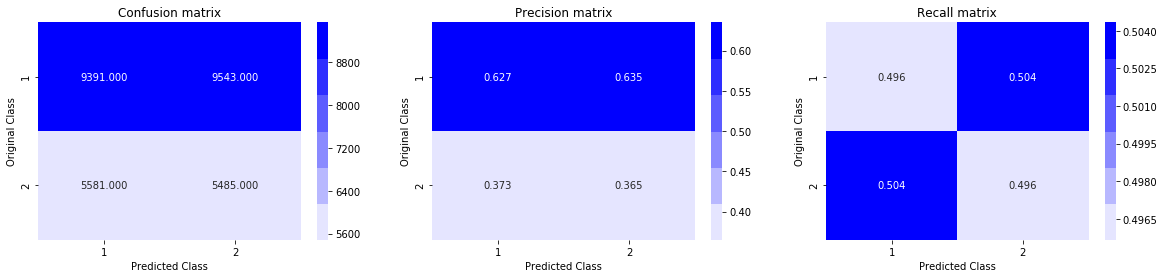

In [28]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(Y_test, predicted_y)

# <h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

### Set1

For values of alpha =  1e-05 The log loss is: 0.548743742225673
For values of alpha =  0.0001 The log loss is: 0.5467087944127236
For values of alpha =  0.001 The log loss is: 0.566503694247282
For values of alpha =  0.01 The log loss is: 0.54578084571884
For values of alpha =  0.1 The log loss is: 0.5330666287540001
For values of alpha =  1 The log loss is: 0.5532146319286294
For values of alpha =  10 The log loss is: 0.5653129252987725


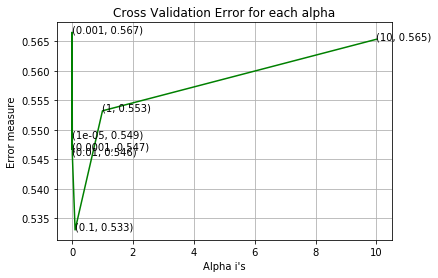

For values of best alpha =  0.1 The train log loss is: 0.5071599372950418
For values of best alpha =  0.1 The test log loss is: 0.5330666287540001
Total number of data points : 30000


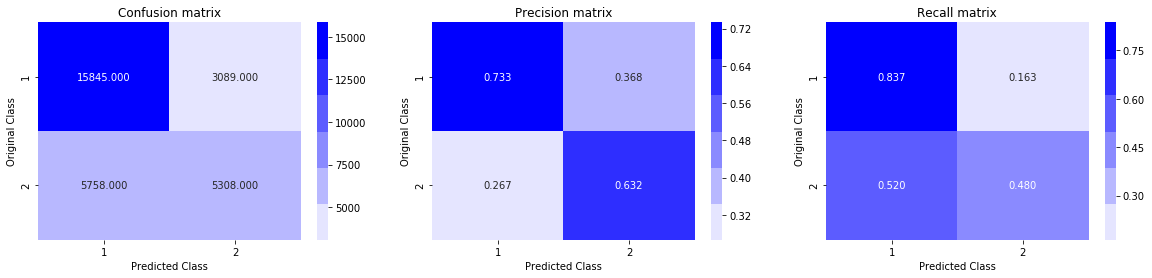

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.  # [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(X_train_set1, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") # since we are using Log loss its best to use the Calibrated Classifier
    sig_clf.fit(X_train_set1, Y_train) # Fitting the train data
    predict_y = sig_clf.predict_proba(X_test_set1) # Predicting the proabability for test data
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))# here we are passing orginal value and Predicted probability
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15)) # here we are passing orginal value and Predicted probability

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(X_train_set1, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_set1, Y_train)

predict_y = sig_clf.predict_proba(X_train_set1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_set1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Observation:

* Logistic regression with L2 regularization model is used with alpha of 0.1
* Here 115845 points are correctly predicted as non-duplicate Questions (83%)
* But only 48% are correctly predicted as Similar Questions which is worse than random model
* Here data is imbalanced, more number of Non-similar questions are there that could be the reason for low Recall of Duplicate Qustions

### Set2

For values of alpha =  1e-05 The log loss is: 0.47342509560735474
For values of alpha =  0.0001 The log loss is: 0.48338606906794895
For values of alpha =  0.001 The log loss is: 0.4829171520442586
For values of alpha =  0.01 The log loss is: 0.5282652067054792
For values of alpha =  0.1 The log loss is: 0.5438029038338746
For values of alpha =  1 The log loss is: 0.5640635001468499
For values of alpha =  10 The log loss is: 0.5900812400096875


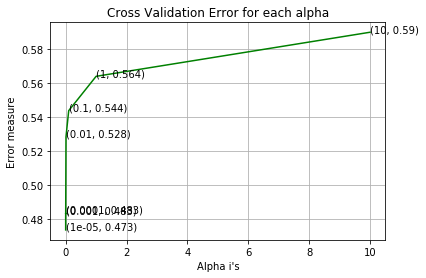

For values of best alpha =  1e-05 The train log loss is: 0.44733523296217137
For values of best alpha =  1e-05 The test log loss is: 0.47342509560735474
Total number of data points : 30000


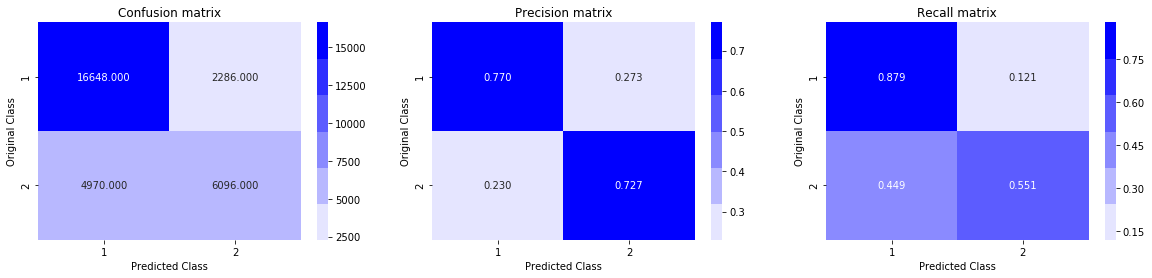

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.  # [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(X_train_set2, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") # since we are using Log loss its best to use the Calibrated Classifier
    sig_clf.fit(X_train_set2, Y_train) # Fitting the train data
    predict_y = sig_clf.predict_proba(X_test_set2) # Predicting the proabability for test data
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))# here we are passing orginal value and Predicted probability
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15)) # here we are passing orginal value and Predicted probability

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(X_train_set2, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_set2, Y_train)

predict_y = sig_clf.predict_proba(X_train_set2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_set2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Observation:

* Logistic regression with L2 regularization model is used with alpha of 1e-05
* Here 16648 points are correctly predicted as non-duplicate Questions (87%) which is greater than set1
* 55% are correctly predicted as Similar Questions which is better than random model and Set1 
* Here data is imbalanced, more number of Non-similar questions are there that could be the reason for low Recall of Duplicate Qustions

# <h2> 4.5 Linear SVM with hyperparameter tuning </h2>

### Set 1

For values of alpha =  1e-05 The log loss is: 0.658352917659378
For values of alpha =  0.0001 The log loss is: 0.5527122120073963
For values of alpha =  0.001 The log loss is: 0.5550480845006631
For values of alpha =  0.01 The log loss is: 0.5605808149166543
For values of alpha =  0.1 The log loss is: 0.6362629361871239
For values of alpha =  1 The log loss is: 0.658352917659378
For values of alpha =  10 The log loss is: 0.658352917659378


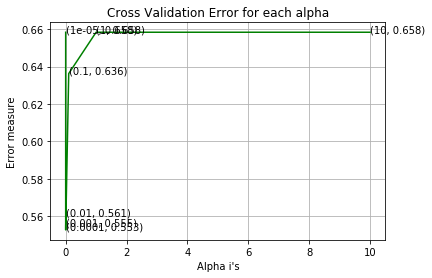

For values of best alpha =  0.0001 The train log loss is: 0.5287313233618245
For values of best alpha =  0.0001 The test log loss is: 0.5527122120073963
Total number of data points : 30000


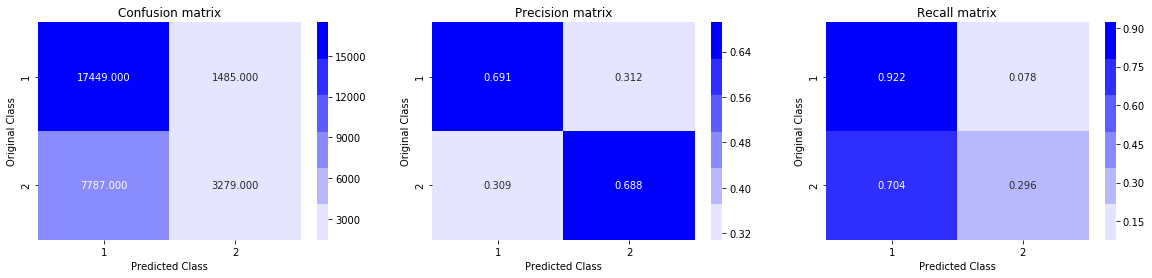

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_set1, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_set1, Y_train)
    predict_y = sig_clf.predict_proba(X_test_set1)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_set1, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_set1, Y_train)

predict_y = sig_clf.predict_proba(X_train_set1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_set1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Observation:

* Support vector Machine with L1 regularization model is used with alpha of 0.0001
* Here 17449 points are correctly predicted as non-duplicate Questions (92%) which is greater than Logistic Regression
* Only 29% are correctly predicted as Similar Questions which is worse than random model
* Here data is imbalanced, more number of Non-similar questions are there that could be the reason for low Recall of Duplicate Qustions

### Set1 Balanced

For values of alpha =  1e-05 The log loss is: 0.658352917659378
For values of alpha =  0.0001 The log loss is: 0.5478310813658778
For values of alpha =  0.001 The log loss is: 0.5561027055189701
For values of alpha =  0.01 The log loss is: 0.5632832114533851
For values of alpha =  0.1 The log loss is: 0.6171866606306062
For values of alpha =  1 The log loss is: 0.6367137396061106
For values of alpha =  10 The log loss is: 0.658352917659378


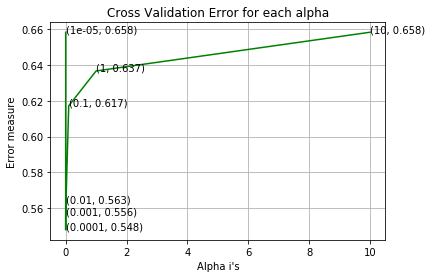

For values of best alpha =  0.0001 The train log loss is: 0.5215933639174846
For values of best alpha =  0.0001 The test log loss is: 0.5460504238159406
Total number of data points : 30000


NameError: ignored

In [24]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, class_weight ="balanced", penalty='l1', loss='hinge', random_state=42 )
    clf.fit(X_train_set1, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_set1, Y_train)
    predict_y = sig_clf.predict_proba(X_test_set1)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], class_weight ="balanced", penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_set1, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_set1, Y_train)

predict_y = sig_clf.predict_proba(X_train_set1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_set1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

For values of best alpha =  0.0001 The train log loss is: 0.5215933639174846
For values of best alpha =  0.0001 The test log loss is: 0.5460504238159406
Total number of data points : 30000


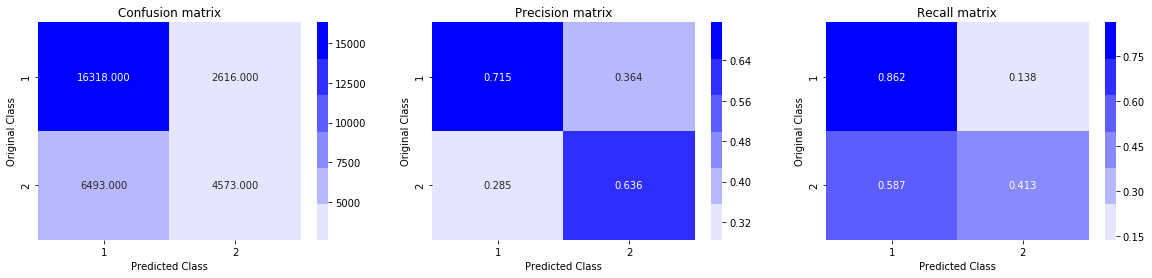

In [29]:
predict_y = sig_clf.predict_proba(X_train_set1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_set1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Observation:

* Support vector Machine with L1 regularization model is used with alpha of 0.0001
* Here 16318 points are correctly predicted as non-duplicate Questions (86%) 
* Only 41% are correctly predicted as Similar Questions which is worse than random model
* Here data is Balanced

### Set 2

For values of alpha =  1e-05 The log loss is: 0.46895897758865124
For values of alpha =  0.0001 The log loss is: 0.46877107166143256
For values of alpha =  0.001 The log loss is: 0.49533290712268535
For values of alpha =  0.01 The log loss is: 0.5201490208427694
For values of alpha =  0.1 The log loss is: 0.5390691219211111
For values of alpha =  1 The log loss is: 0.5611205737619406
For values of alpha =  10 The log loss is: 0.5868616079947948


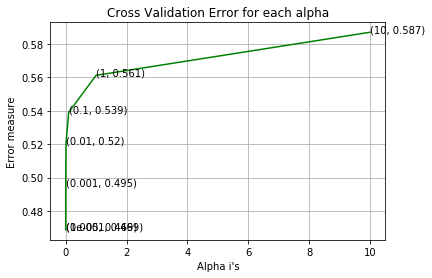

For values of best alpha =  0.0001 The train log loss is: 0.5001877443160299
For values of best alpha =  0.0001 The test log loss is: 0.5211969404297754
Total number of data points : 30000


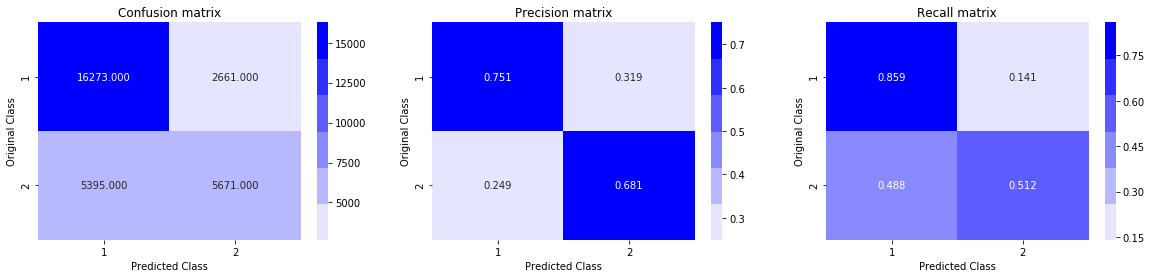

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_set2, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_set2, Y_train)
    predict_y = sig_clf.predict_proba(X_test_set2)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_set2, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_set2, Y_train)

predict_y = sig_clf.predict_proba(X_train_set2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_set2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Observation:

* Support vector Machine with L2 regularization model is used with alpha of 0.0001 on Set2
* Here 16273 points are correctly predicted as non-duplicate Questions (85%)
* Only 51% are correctly predicted as Similar Questions which is better than Set2 SVM
* Here data is imbalanced, more number of Non-similar questions are there that could be the reason for low Recall of Duplicate Qustions

# <h2> 4.6 XGBoost </h2>


    Gradient Boosting algorithm also called gradient boosting machine including the learning rate.
    Stochastic Gradient Boosting with sub-sampling at the row, column and column per split levels.
    Regularized Gradient Boosting with both L1 and L2 regularization.
    
    # https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
    
    # https://github.com/dmlc/xgboost/tree/master/demo
    
    # https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
    
    # https://xgboost.readthedocs.io/en/latest//parameter.html
    
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    
    # https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
    
    # https://github.com/xoelop/Medium-posts/blob/master/3d%20cross%20validation/ML%206%20-%20Gridsearch%20visulizations%20.ipynb
    
    # https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

## Sample XGBOOST on set 1without Hyperparameter tuning 

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_set1, label=Y_train)
d_test = xgb.DMatrix(X_test_set1, label=Y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_set1,Y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.685802	valid-logloss:0.686562
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.6255	valid-logloss:0.632424
[20]	train-logloss:0.581416	valid-logloss:0.592762
[30]	train-logloss:0.548124	valid-logloss:0.562819
[40]	train-logloss:0.522677	valid-logloss:0.539975
[50]	train-logloss:0.502669	valid-logloss:0.521975
[60]	train-logloss:0.486754	valid-logloss:0.507625
[70]	train-logloss:0.474046	valid-logloss:0.496062
[80]	train-logloss:0.463565	valid-logloss:0.486382
[90]	train-logloss:0.455047	valid-logloss:0.478683
[100]	train-logloss:0.447766	valid-logloss:0.472267
[110]	train-logloss:0.441697	valid-logloss:0.46694
[120]	train-logloss:0.436465	valid-logloss:0.46255
[130]	train-logloss:0.432142	valid-logloss:0.458625
[140]	train-logloss:0.42842	valid-logloss:0.455444
[150]	train-logloss:0.425197	valid-logloss:0.452611
[160]	train-logloss:0.42237	valid

Total number of data points : 30000


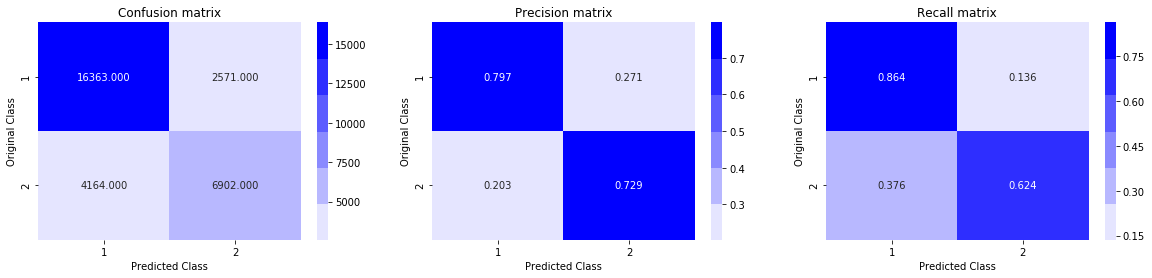

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Observation:

* XGBOOST on set1
* Here 16363 points are correctly predicted as non-duplicate Questions (86%)
* 52% are correctly predicted as Similar Questions which is better than Set2 SVM
* Here data is imbalanced, more number of Non-similar questions are there that could be the reason for low Recall of Duplicate Qustions

#### Testing Random search

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV	


tuned_parameters = {'n_estimators': [1, 10],'max_depth': [3]}  # two hyperparameter combinations


clf = GridSearchCV(XGBClassifier(class_weight='balanced', n_jobs=-1, objective='binary:logistic'), tuned_parameters, scoring='neg_log_loss', cv=5, 
                   return_train_score=True,  n_jobs=-1, verbose=10)


clf.fit(X_train_set1, Y_train)
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
print(train_auc)
print(cv_auc)
print(clf)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished


[-0.66071208 -0.5161694 ]
[-0.66074113 -0.51674553]
GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     class_weight='balanced',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3], 'n_estimato

In [0]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## XGboost With hypermater Tuning (Random search)

### Set 1

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV	



# eta = learning rate

tuned_parameters = {'n_estimators': [1, 10],'max_depth': [3, 5, 7, 10], 'eta': [0.01, 0.1, 0.3], 'subsample' : [0.5, 0.8, 1],
                   'colsample_bytree' : [0.5, 0.8, 1], 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],  'gamma':[i/10.0 for i in range(0,5)],
                   'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]}  # two hyperparameter combinations


clf = RandomizedSearchCV(XGBClassifier(class_weight='balanced', n_jobs=-1, objective='binary:logistic', eval_metric = "logloss"), 
                         tuned_parameters, scoring=None, cv=5, return_train_score=True,  n_jobs=-1, verbose=10)


clf.fit(X_train_set1, Y_train)
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
print(train_auc)
print(cv_auc)
print(clf)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.0min finished


[0.80311071 0.77518214 0.70986786 0.78672857 0.77755357 0.741075
 0.77355714 0.79736786 0.76249643 0.80816071]
[0.78564286 0.77261429 0.70955714 0.77965714 0.76827143 0.73954286
 0.76512857 0.78251429 0.75482857 0.76984286]
RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           class_weight='balanced',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
         

In [0]:
print(train_auc)
print(cv_auc)

[0.80311071 0.77518214 0.70986786 0.78672857 0.77755357 0.741075
 0.77355714 0.79736786 0.76249643 0.80816071]
[0.78564286 0.77261429 0.70955714 0.77965714 0.76827143 0.73954286
 0.76512857 0.78251429 0.75482857 0.76984286]


In [0]:
xgboost_set1_params = pd.DataFrame()

In [0]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              eta=0.01, eval_metric='logloss', gamma=0.1, learning_rate=0.1,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
              n_estimators=10, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=1e-05,
              reg_lambda=100, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.5, verbosity=1)

#### Using best parameters for fitting and predicting the test_set

In [33]:
# here number of base estimaters are increased 
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

xg = XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              eta=0.01, eval_metric='logloss', gamma=0.1, learning_rate=0.1,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=1e-05,
              reg_lambda=100, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.5, verbosity=3)

xg.fit(X_train_set1, Y_train)

y_predict = xg.predict_proba(X_test_set1)

print(log_loss(Y_test,y_predict))


[12:47:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 70 pruned nodes, max_depth=10
[12:47:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 26 pruned nodes, max_depth=10
[12:47:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 44 pruned nodes, max_depth=10
[12:47:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 24 pruned nodes, max_depth=10
[12:47:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 44 pruned nodes, max_depth=10
[12:47:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 42 pruned nodes, max_depth=10
[12:47:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 60 pruned nodes, max_depth=10
[12:47:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 

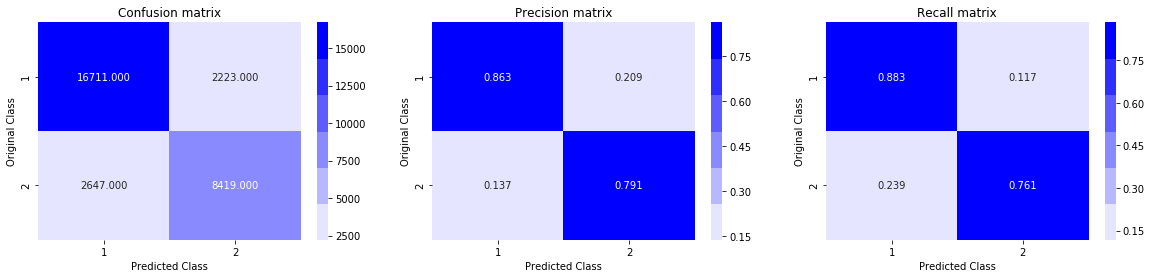

In [55]:
Y_predicted = xg.predict(X_test_set1)
plot_confusion_matrix(Y_test, Y_predicted)

## Observation:

* XGBOOST on set1 with Hyperparameter tuning using Randomsearch
* Here 16711 points are correctly predicted as non-duplicate Questions (86%)
* 79% are correctly predicted as Similar Questions which is better all other models
* As we see, both Precision and Recall is good for Similar and Non-similar Questions
* Here data is Balanced
* XGboost for set 2 is not tried, since the Dimention of set2 is very high (>20000)

<h1> Conclusion</h1>

In [57]:
#  http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

table = PrettyTable()
table.field_names= ("S NO","Vectorizer", "Algorithm", "HyperParameter  ", "Test_data: Log_loss","Test_data TPR","Test_data FPR")
table.add_row(["Model_1","Tfidf_weighted_w2v", "Logistic Regression", "(Alpha) = (0.1)", 0.533,0.83,0.48])
table.add_row(["Model_2","Tf-idf", "Logistic Regression", "(Alpha) = (1e-05)",  0.4734,0.87,0.55])
table.add_row(["Model_3","Tfidf_weighted_w2v", "Linear Support Vector Machine", "(Alpha) = (0.0001)", 0.5527,0.92,0.29])
table.add_row(["Model_4","Tf-Idf weighted W2v", "Linear Support Vector Machine", "(Alpha) = (0.0001) + Dataset Balanced",0.546,0.86,0.51])
table.add_row(["Model_5","Tf-idf", "Linear Support Vector Machine", "(Alpha) = (0.0001)", 0.52,0.85,0.51])
table.add_row(["Model_6","Tfidf_weighted_w2v", "Xgboost", "(colsample_bytree=0.8, max_depth=10, reg_alpha=1e-05, reg_lambda=100, subsample=0.5, gamma=0.1, learning_rate=0.1, n_estimators=1000)", 0.337092,0.85,0.79])
print('\n')
print("Quora Question Pair Similarity Case Study")
print(table)



Quora Question Pair Similarity Case Study
+---------+---------------------+-------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+--------------------+---------------+---------------+
|   S NO  |      Vectorizer     |           Algorithm           |                                                            HyperParameter                                                             | Test data Log_loss | Test_data TPR | Test_data FPR |
+---------+---------------------+-------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+--------------------+---------------+---------------+
| Model_1 |  Tfidf_weighted_w2v |      Logistic Regression      |                                                            (Alpha) = (0.1)                                                   

In [0]:

# Sample code for Randomsearch

# From Datacamp
"""


# Create the parameter grid: gbm_param_grid 

gbm_param_grid = {
    'n_estimators': [25],
    'max_depth': range(2, 12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid,
                                    n_iter=5, scoring='neg_mean_squared_error', cv=4, verbose=1)
randomized_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ",randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))


"""